In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time


from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq
from triqs_tprf.lattice import inv

from itertools import product

from gwsolver import GWSolver
from exact_diag import exact_diag, ed_occupation, ed_mu
from pino import exact_g, analytical_g

from hubbard import GWHubbardDimer


matplotlib.rcParams.update({'font.size': 22})

Starting serial run at: 2024-03-12 16:20:18.300272


In [15]:
def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij
    g = inv(g_inv, 8)
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)


def N(g_w):
    return g_w.total_density().real


def hopping_1d(orbitals, t):
    t = 1.0
    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t
    return tij 

def hopping_matrix(N, M, t):
    return np.kron(hopping_1d(N, t), np.eye(M)) + np.kron(np.eye(N), hopping_1d(M, t))

def distance_matrix(N, M):
    X = np.arange(N * M) // M
    Y = np.arange(N * M) % M
    return np.sqrt((X[:, None] - X) ** 2 + (Y[:, None] - Y) ** 2)

def coulomb_matrix(N, M, V, non_local = False):
    if not non_local:
        return np.eye(N * M) * V
    return V / (1 + distance_matrix(N, M))

def coulomb_tensor(N, M, V, non_local = False):
    Vij = coulomb_matrix(N, M, V, non_local)
    Vijkl = np.zeros([N * M] * 4)
    for i in range(N * M):
        for j in range(N * M):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

def symmetric_difference(omega, value, A):
    w_index = np.argmin(np.abs(omega - value))

    left_sum = np.sum(A[:w_index])
    right_sum = np.sum(A[w_index:])
    return left_sum - right_sum

def find_center_freq(g):
    omega = np.array([w for w in g.mesh.values()])
    A = spectral(g)

    w_step = 5.0

    w = 0
    difference = symmetric_difference(omega, w, A)
    last_difference = 2 * difference

    previous_direction = None
    iter = 0
    while abs(difference) > 0.0001:
        if abs(difference - last_difference) < 1e-6:
            break

        iter += 1
        if difference < 0:
            if previous_direction == 'decrement':
                w_step /= 2
            previous_direction = 'increment'
            w += w_step
        else:
            if previous_direction == 'increment':
                w_step /= 2
            previous_direction = 'decrement'
            w -= w_step

        last_difference = difference
        difference = symmetric_difference(omega, w, A)
    
    return w

def offset(g_w, w, w_center_arg):
    return np.argmin(np.abs(w - find_center_freq(g_w))) - w_center_arg

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def plot(a, b, spin = 'up'):
    orbitals = len(a[spin].data[0, 0, :])
    fig, axs = plt.subplots(orbitals, orbitals, figsize = (10 * orbitals, 10 * orbitals), facecolor = 'black')
    spin = 'up'


    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].xaxis.label.set_fontsize(20)

            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1, s = 20)
            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'red', zorder = 1, s = 20)

            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'white', zorder = 0)
            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'white', zorder = 0)

def GWtoED(x, y, N_fix, t, U, beta = 20, max_iter = 1, non_local = False, pade = False):

    def rel_error(ed, g):
        size = len(list(g.mesh.values()))
        errors = np.zeros((size, x * y, x * y)) * 1j
        for i, w in enumerate(g.mesh):
            ed = ED['up'](w)
            g_up = g['up'].data[i, :, :]
            errors[i] = (ed - g_up) / ed

        return 100 * np.max(np.abs(errors))

    tij = hopping_matrix(x, y, t)

    Vij = coulomb_matrix(x, y, U, non_local = non_local)
    Vijkl = coulomb_tensor(x, y , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    ED, mu_ed = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)

    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = max_iter, full_mesh = pade)
    
    print(f'g0_w occupation: {round(N(gw.g0_w), 5)}, Chemical potential: {gw.mu0}')
    print(f'g_w occupation: {round(N(gw.g_w), 5)}, Chemical potential: {gw.mu}')
    print(f'ED occupation: {round(N(ED), 5)}, Chemical potential: {mu_ed}')
    print(f'Max rel. error: {round(rel_error(ED, gw.g_w), 2)}%')
    print(f'Iteration reached: {gw.iter_reached}')
    # print(N(ED))
    # print(gw.mu)
    if not pade:
        plot(gw.g_w, ED)
        return

    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))


    G_w_temp = Gf(mesh = w_mesh, target_shape = [x * y, x * y])
    G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        G_w[block].set_from_pade(ED[block], n_points = 100, freq_offset = 0.1)

    g_w_temp = Gf(mesh = w_mesh, target_shape = [x * y, x * y])
    g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        g_w[block].set_from_pade(gw.g_w[block], n_points = 100, freq_offset = 0.1)


    G_w_offset = offset(G_w, w, w_center_arg)

    fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.set_xlim(w_min, w_max)

    ax.plot([w for w in G_w.mesh.values()][w_min_arg:w_max_arg], spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'white', zorder = 0)
    ax.scatter([w for w in g_w.mesh.values()][w_min_arg:w_max_arg], spectral(g_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'red', s = 3, zorder = 1)
    plt.show()
    return


g0_w occupation: 4.0, Chemical potential: 0
g_w occupation: 2.0, Chemical potential: 0.0
ED occupation: 1.99999, Chemical potential: 0
Max rel. error: 0.84%
Iteration reached: 8


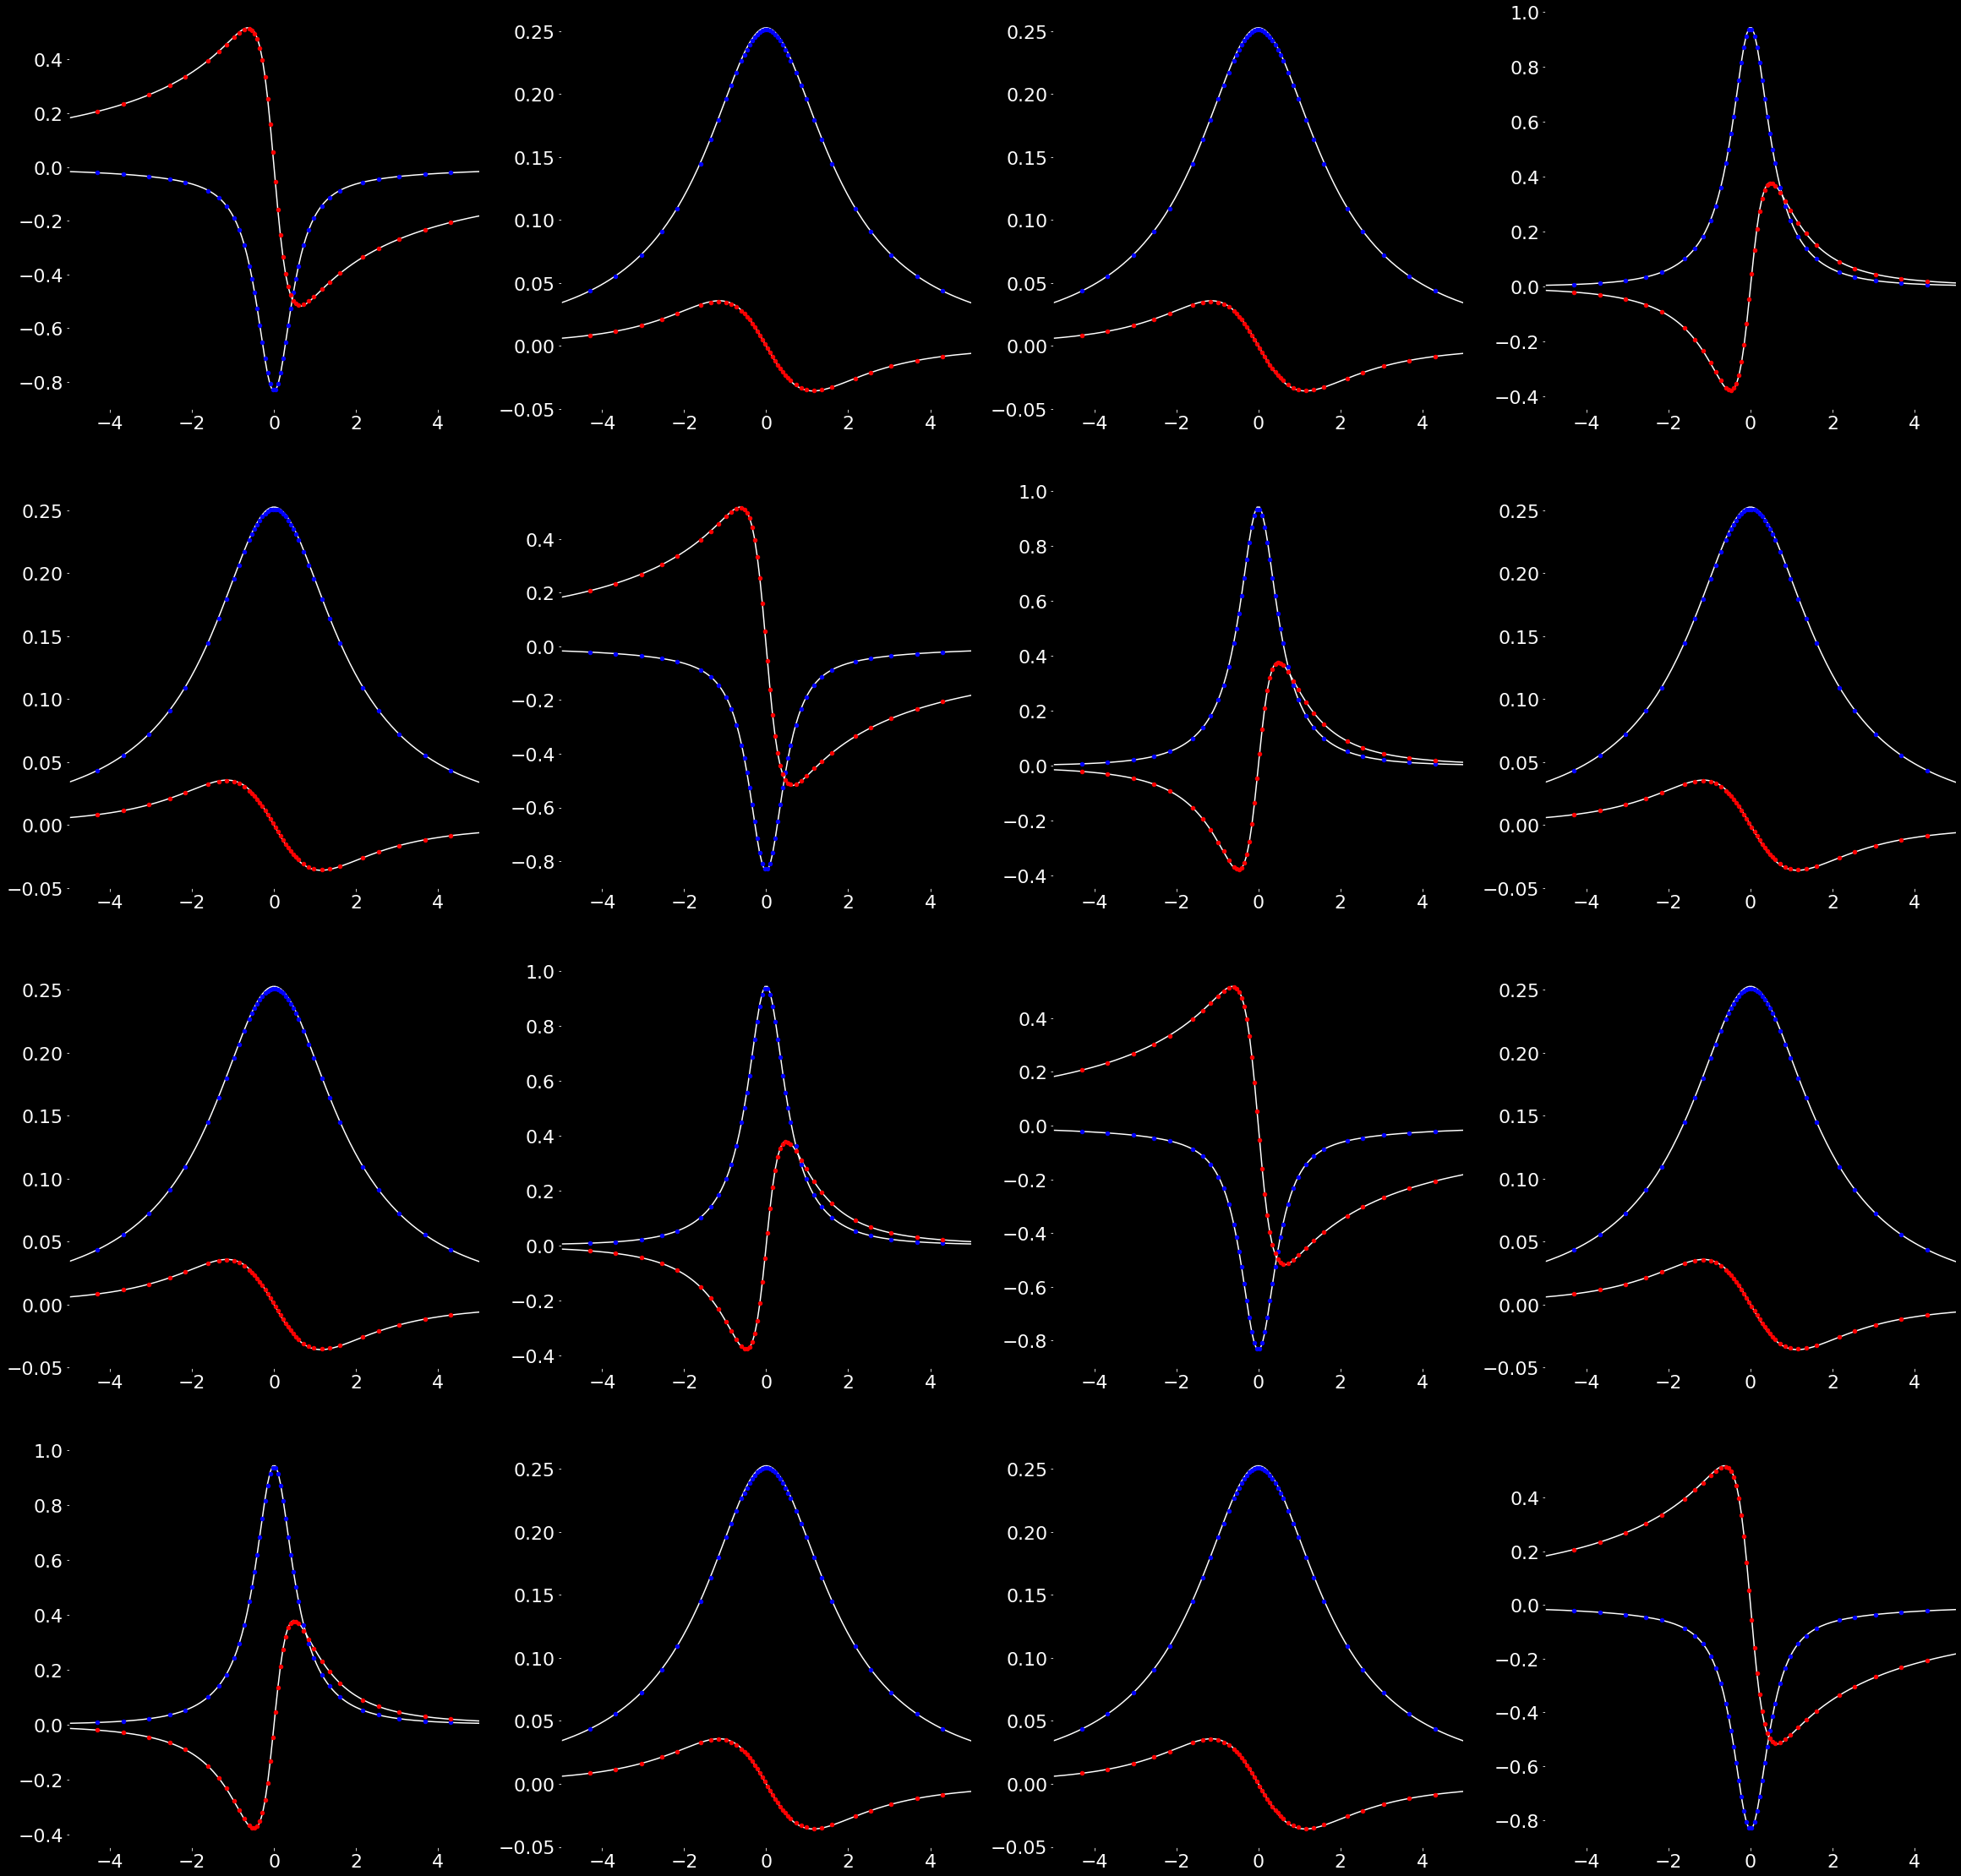

In [16]:
GWtoED(x = 2, y = 2, N_fix = False, t = 1.0, U = 1.5, beta = 100, max_iter = 25, non_local = True, pade = False)

g0_w occupation: 6.0, Chemical potential: 0
g_w occupation: 4.0, Chemical potential: 0.0
ED occupation: 3.99997, Chemical potential: 0
Max rel. error: 1.56%
Iteration reached: 8


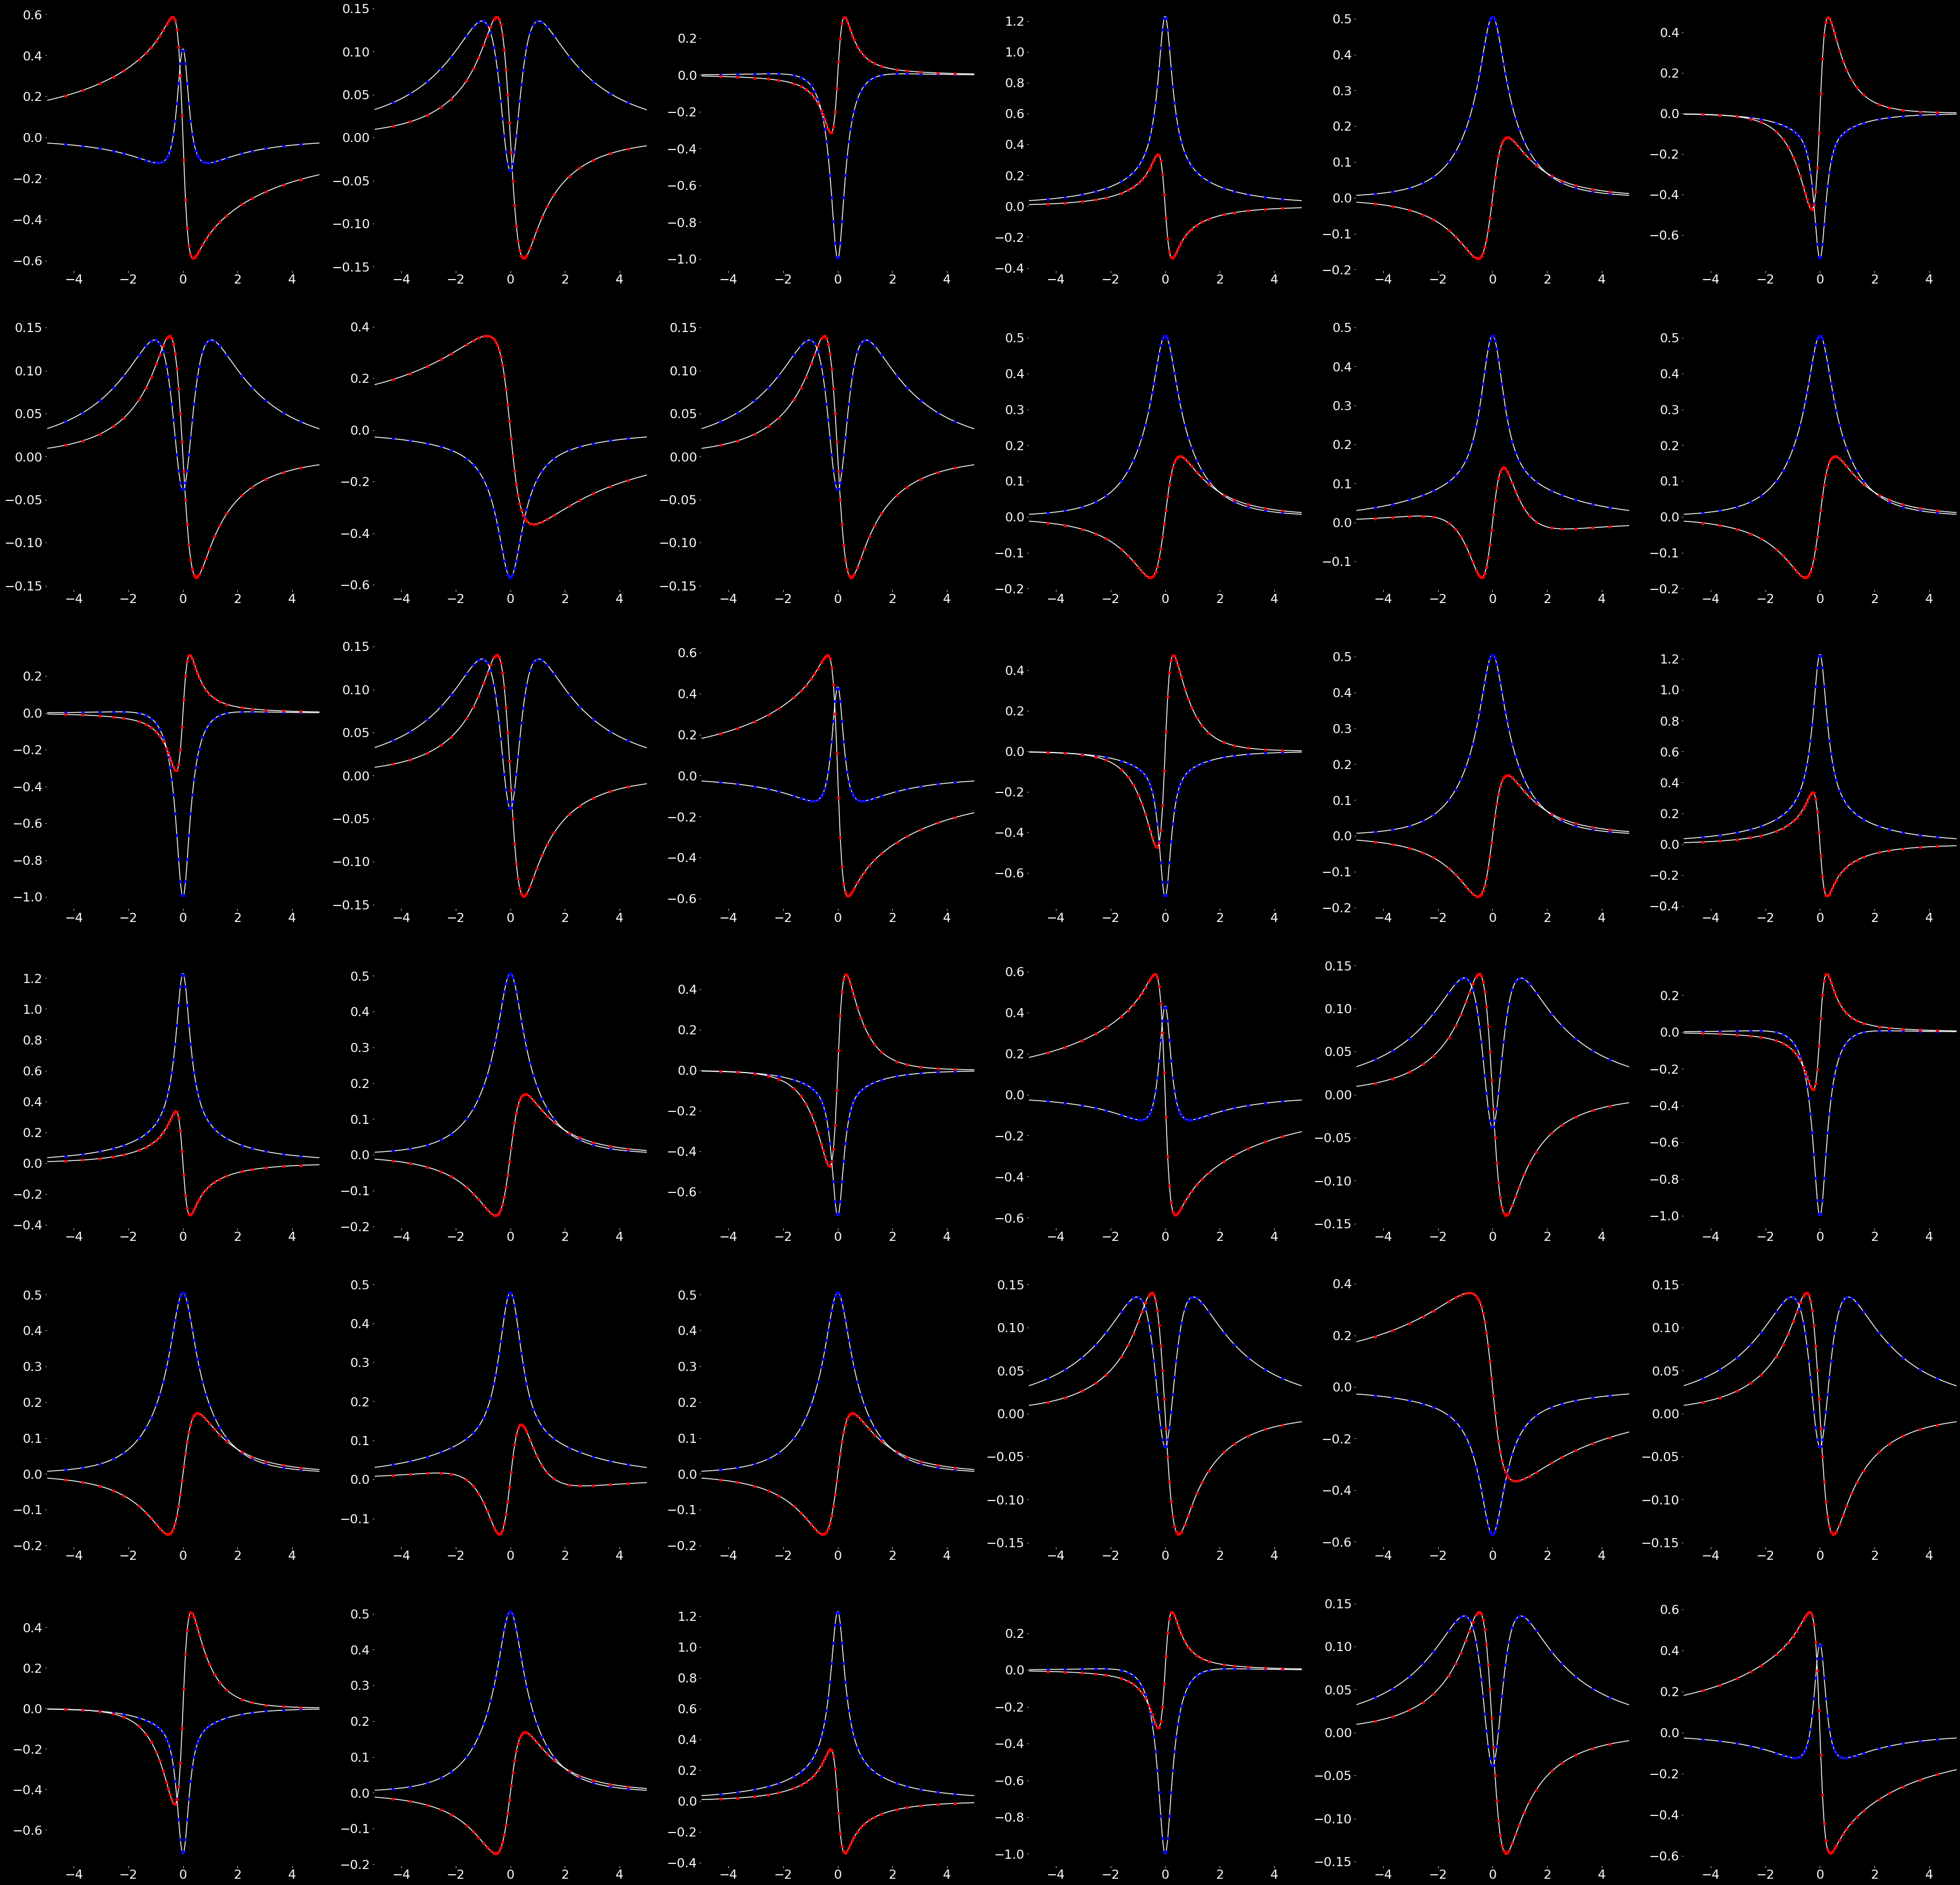

In [11]:
GWtoED(x = 2, y = 3, N_fix = False, t = 1.0, U = 0.5, beta = 100, max_iter = 25, non_local = True, pade = False)